Materijali zasnovani na [zvaničnom](https://www.tensorflow.org/tutorials/keras/classification) TensorFlow tutorial-u.

# Osnovna klasifikacija: Skup podataka `Fashion MNIST`

U ovom primeru ćemo obučavati neuronsku mrežu da klasifikuje fotografije
odeće iz skupa podataka `Fashion MNIST`.

Za realizaciju ćemo koristiti biblioteku `keras` (skoro integrisanu )
u biblioteci `tensorflow`. Biblioteka `keras` je integrisana u `tensorflow`
počevši od verzije `2.0` i na dalje se preporučuje njeno korišćenje
iz `tensorflow`-a. Ranije je bilo neophodno instalirati `keras` i podršku
za izračunavanje (`tensorflow`, `theano`, `cntk`) odvojeno. Usled popularnosti
biblioteke `keras`, integrisana je u `tensorflow`.

In [1]:
# Ucitavamo tensorflow
import tensorflow as tf
# Ucitavamo keras
from tensorflow import keras

# Pomocne biblioteke
import numpy as np
import matplotlib.pyplot as plt

# Korisno ako koristite tamnu temu, slike ce se bolje videti.
plt.style.use('dark_background')

# Korisno je uvek ostaviti ispisane verzije biblioteka koje su koriscene kako bi
# drugi ljudi imali tu informaciju pri pokretanju vasih sveski.
print(tf.__version__)

2.2.0-rc3


## Skup podataka `Fashion MNIST`

Ovaj primer koristi [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) skup podataka koji sadrži 70,000 crno belih slika koje su
podeljene u 10 kategorija. Jedna slika sadrži jedan komad odeće ili obuće.
Rezolucija slike je $28 \times 28$ piksela.

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Slika 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST primeri</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST je namenjen kao zamena za tradicionalni [MNIST](http://yann.lecun.com/exdb/mnist/) skup podataka koji se ranije često koristio kao prvi
ilustrativni skup podataka za klasifikaciju (sa slikama). `MNIST` sadrži
slike rukom pisanih cifara u vrlo sličnom formatu kao prethodno opisano
za `Fashion MNIST`.

`Fashion MNIST` je nešto teži skup podataka u odnosu na `MNIST`, no oba skupa
su izuzetno čista (nema šuma, odstupanja u uglovima fotografije, relativno
slično osvetljenje), te rešavanju klasifikacionog problema na njima nije
teško.

U ovom primeru ćemo koristiti 60,000 slika da obučimo mrežu, a ostalih 10,000
slika da evaluiramo koliko precizno je naša mreža klasifikovala slike.

Pošto je `Fashion MNIST` relativno poznat skup koji se često koristi,
nije retkost da biblioteke pružaju pomoćne funkcije za njegovo preuzimanje
i korišćenje.

In [ ]:
fashion_mnist = keras.datasets.fashion_mnist

# Funkcija vraca dva uredjena para kod kojih je prvi element niz
# slika, a drugi element niz labela za slike.
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

Preciznije rečeno, funkcija nam vraća `numpy` nizove:

* `train_images` i `train_labels` nizovi su skup podataka za obučavanje modela
* Model se testira na skupu za testiranje, `test_images`, i `test_labels` sadrže
potrebne podatke.

Slike su `numpy` nizovi oblika (28, 28) sa pikselima čije vrednosti se nalaze
u opsegu celih brojeva od 0 do 255 (uključujući obe vrednosti).
Labele (`train_labels` i `test_labels`) predstavljaju niz brojeva sa vrednostima
0, 1, 2, ..., 9 koji predstavljaju oznaku kategorije kojoj pripada instanca.

Radi manje konfuzije, imena klasa će biti ostavljena na engleskom jeziku.

<table>
  <tr>
    <th>Labela</th>
    <th>Klasa</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>


In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Analiza skupa podataka

Pogledajmo malo skup podataka detaljnije.

Na primer, postoji 60,000 instanci u skupu za obučavanje čija je
rezolucija $28 \times 28$. Nizovi iz biblioteke `numpy` imaju svoj *oblik*
(eng. shape) koji definišu njihovu dimenzionalnost.

In [4]:
train_images.shape

(60000, 28, 28)

Takođe, očekujemo da postoji 60,000 labela u labelama za obučavanje.

In [5]:
len(train_labels)

60000

In [6]:
train_labels.shape

(60000,)

Svaka labela je ceo broj iz intervala [0, 9].

In [7]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [8]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

Postoji 10,000 slika u skupu za obučavanje. Takođe, slike su rezolucije
$28 \times 28$.


In [9]:
test_images.shape

(10000, 28, 28)

Skup za testiranje takođe treba da sadrži 10,000 labela.

In [10]:
len(test_labels)

10000

## Pretprocesiranje podataka

Pretprocesiranje podataka predstavlja važan korak u većini primena u okviru
problema klasifikacije (i regresije). Oblik u kome dobijemo podatko često
nije dovoljno pogodan za algoritme koje želimo da koristimo te je potrebno
izvršiti određene transformacije kako bi se to nadomestilo.

Treba pažljivo uraditi analizu skupa podataka koji se koristi jer taj korak
često definiše dalje korake - kao što su pretprocesiranje i odabir algoritama.

Pogledajmo koje vrednosti uzimaju pikseli slika u našem skupu.

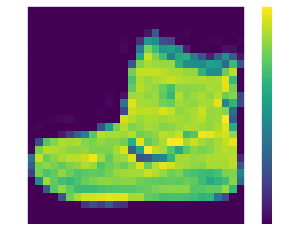

In [11]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

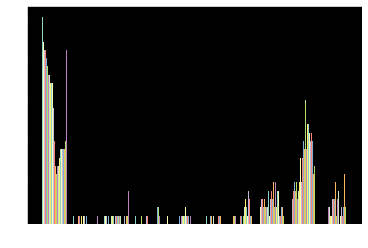

In [12]:
_ = plt.hist(train_images[0])

Piksele možemo skalirati na interval [0, 1]. Važno je biti pažljiv pri
primeni pretprocesiranja jer treba primeniti transformacije i nad skupom
za obučavanje i nad skupom za testiranje.

In [ ]:
train_images = train_images / 255.0

test_images = test_images / 255.0

Možemo proveriti da li su slike u korektnom formatu. Na primer, možemo
nacrtati prvih 25 slika iz skupa za obučavanje i prikazati ime klase
ispod svake slike.

SAVET: Često je potrebno crtati mrežu slika dimenzija $A \times B$,
zapamtite kako se ovo radi.

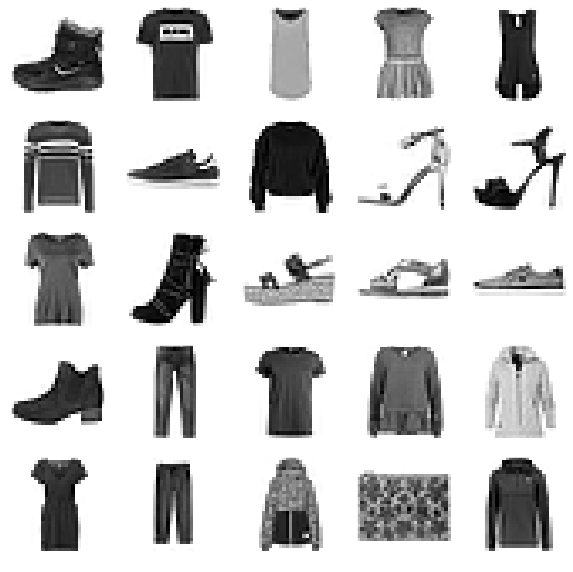

In [14]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## Kreiranje modela

Biblioteke `keras` i `tensorflow` imaju veliku podršku za definisanje
različitih modela na nekoliko načina u zavisnosti od potreba. U ovom primeru
ćemo prikazati jednostavan primer iz biblioteke `keras` koji definiše
mrežu kao sekvencu slojeva sa propagacijom unapred.

Nakon toga, biće neophodno izvršiti kompilaciju mreže kako bi sistem za
izračunavanje (eng. backend, ovde je to `tensorflow`) mogao da je koristi.

### Definisanje slojeva

Sloj (eng. layer) je osnovni termin i element koji se koristi za definisanje
arhitekture mreže. Postoje razni slojevi, ali ono što im je uglavnom svima
zajedničko je da vrše neku transformaciju podataka sa ulaza i transformisani
rezultat prosleđuju na izlaz.


`tf.keras.layers.Flatten` će prosleđeni oblik podataka izravnati, odnosno u
našem slujačaju će dimenziju $28 \times 28$ pretvoriti u 784.

`tf.keras.layers.Dense` će nam omogućiti da definišemo potpuno povezani sloj
neurona sa njihovim težinama i aktivacijama.


`tf.keras.Sequential` je objekat koji konstruišemo iz liste slojeva koji
definišu arhitekturu naše mreže.

In [ ]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

Kako nam je ulaz slika oblika (28, 28), neophodno je to transformisati
u oblik koji potpuno povezana mreža može da prihvati. Sloj `Flatten`
upravo radi takvu transformaciju.

Na dalje definišemo potpuno povezani sloj sa 128 neurona i `relu` aktivacijom.
Ovaj sloj na svom ulazu dobija 784 broja (ili vektor dimenzije 784) koji
transformiše u novi vektor dimenzije 128.

Sledeći sloj definišemo da ima 10 neurona koji transformišu vektor dimenzije
128 u vektor dimenzije 10. Izlazi predstavljaju ocenu o pripadnosti instance
klasama koje postoje. Postavljamo `softmax` aktivaciju kako bi se funkcija
mekog maksimuma primenila na izlazu mreže i izlaz transformisala na raspodelu
verovatnoće.

### Kompilacija modela

Pre nego što pokrenemo obučavanje modela, potrebno je da ga prevedemo u oblik
pogodan za operacije koje `tensorflow` treba da izvede (izračunavanje
gradijenata, ažuriranje težina i slično).

Treba definisati:

- **funkciju gubitka** (eng. loss) koja meri koliko model greši.
Ovu funkciju želimo da minimizujemo i time usmerimo model u pravom smeru
tokom procesa obučavanja.
- **optimizator** - algoritam koji se koristi da se ažuriraju koeficijenti
modela
- mere koje se koriste da se prati tok treninga (na primer tačnost)

Mi ćemo definisati:
- Kategoričku kros entropiju (tipična funkcija za multiklasnu klasifikaciju)
- Adam (jedan od popularnijih algoritama)
- Tačnost kao meru koju pratimo

Osim toga, neophodno je da labele (nizove brojeva) transformišemo u
oblik koji je pogodan za izračunavanje greške (kategorička kros entrpija).
Postoji pomoćna funkcija `keras.utils.to_categorical` koja to može uraditi
za nas. Ona će promeniti dimenzinalnost labela tako što će ceo broj X koji
označava klasu zameniti vektorem dužine 10 koji na poziciji X ima broj 1,
a 0 na ostalim. Pogledajte dimenzije pre i posle transformacije u sledećoj
ćeliiji.

In [16]:
# model.compile(optimizer='adam',
            #   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            #   metrics=['accuracy'])

print(train_labels.shape)
train_labels_cat = keras.utils.to_categorical(train_labels)
test_labels_cat = keras.utils.to_categorical(test_labels)
print(train_labels_cat.shape)

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

(60000,)
(60000, 10)


## Obučavanje modela

Obučavanje neuronskih mreža ne prati neki striktan algoritam već dosta često
zavisi i od iskustva, problema, hardvera, skupa podataka i slično.
No često postoji neki opšti postupak koji se može prepoznati u nekim
situacijama.

U našem slučaju, trening će se sastojati iz sledećih delova koji
će se ponavljati (ugrubo):

1. Prosleđivanje podataka iz skupa za obučavanje modelu
1. Model ažurira koeficijente na osnovu ovih podataka
1. Tražimo od modela da predviti kategorije za instance iz skupa za testiranje
1. Izračunavamo tačnost na skupu za testiranje


### Pokretanje obučavanja modela

Biblioteka `keras` poseduje funkciju `fit` koja automatizuje dobar deo
ovog procesa. Kada je naš proces obučavanje modela jednostavan i postoji
neka takva funkcija, to je sasvim dobro, no ukoliko je u pitanju kompleksniji
trening proces, onda je često neophodno spustiti se na niži nivo i ručno
implementirati ove korake (što nije mnogo teže).

Termin epoha označava koliko prolazaka kroz trening skup će biti urađeno.
Ukoliko postavimo da je broj epoha 10, prethodno pomenuti algoritam
ćemo ponoviti 10 puta.

Obučavanje neuronskih mreža je često izuzetno računski intenzivno, a drastična
ubrzanja se mogu postići korišćenjem grafičkih kartica koje su u stanju
da naprave veliki stepen paralelizacije. Google Collab omogućava da dobijemo
grafičku karticu na korišćenje:

```
Runtimes -> Change runtime type -> Hardware accelerator -> GPU
```

### Komentar za GPU podršku

Ukoliko ovo želite da podesite na vašem računaru (ukoliko poseduje adekvatnu
grafičku karticu), potrebno je da instalirate CUDA i propratne biblioteke
kao i `tensorflow-gpu` paket. Ovo nije trivijalno i za potrebe ovog kursa
se savetuje da ipak koristite `Collab`, ili da na vašem kućnom računaru
koristite `tensorflow` paket bez podrške za grafičku karticu.

In [17]:
model.fit(train_images, train_labels_cat, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.5002 - accuracy: 0.8244
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3729 - accuracy: 0.8660
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3367 - accuracy: 0.8782
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3108 - accuracy: 0.8862
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2970 - accuracy: 0.8902
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2798 - accuracy: 0.8965
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2681 - accuracy: 0.9012
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2577 - accuracy: 0.9045
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2458 - accuracy: 0.9086
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.238

Kako se model obučava, možemo da pratimo progres. Praćenje progresa je jako
važno u praksi jer obučavanje modela može da potraje od desetina minuta
pa do nekoliko nedelja (i više...).

Možemo videti koja je trenutno epoha u toku, koliko ukupno epoha treba da se
izvrši, koliko je vremena bilo potrebno za epohu, kao i kolika je funkcija
greške i tačnost.

Možemo primetiti da je na kraju tačnost oko `0.9`.

### Evaluacija tačnosti

Želimo da vidimo kako se model ponaša na skupu za testiranje.

In [18]:
test_loss, test_acc = model.evaluate(test_images,  test_labels_cat, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 1s - loss: 0.3334 - accuracy: 0.8847

Test accuracy: 0.8847000002861023


Možemo primetiti da je tačnost na skupu za testiranje niža nego na skupu
za obučavanje. To je često odlika situacije u kojoj se desilo
preprilagođavanje (eng. overfitting). Preprilagođavanje je situacija
u kojoj je model počeo da uči i neke odlike u podacima koje nisu korisne
za rešavanje problema, na primer šum. Rešavanje problema preprilagođavanja
nije trivijalno u smislu da postoji jasan algoritam koji trepa ispratiti
da bi problem nestao, ali često se svodi na neke stvari poput:

- Koristiti jednostavniji model
- Koristiti regularizaciju
- Ažurirate proces obučavanja
- i slično.

Neki korisni članci relevantni za `keras` i `tensorflow`: [1](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#demonstrate_overfitting)
i [2](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#strategies_to_prevent_overfitting).

### Korišćenje modela

Nakon što je model obučen, možemo da ga koristimo za predikcije na slikama.


In [ ]:
predictions = model.predict(test_images)

Model je predvideo kategoriju za svaku sliku iz skupa za testiranje.

Pogledajmo predikcije za prvu sliku.

In [20]:
predictions[0]

array([1.5322880e-07, 5.5803414e-11, 7.9433875e-08, 5.3310563e-12,
       9.7869511e-11, 1.1631497e-03, 8.1619156e-09, 1.7157016e-02,
       1.2308716e-06, 9.8167831e-01], dtype=float32)

Primetimo da je dobijen niz od 10 brojeva koji predstavljaju ocenu sigurnosti
modela o pripadnosti instance odredjenoj klasi. Određivanje kategorije kojoj
pripada instanca se može uraditi tako što se odredi indeks u ovom nizu
koji ima najveću vrednost.


In [21]:
np.argmax(predictions[0])

9

A to je klasa...

In [22]:
ix = np.argmax(predictions[0])
print(class_names[ix])

Ankle boot


Dakle model misli da je u pitanju kategoriju `Ankle Boot`. Ako pogledamo
u podacima možemo zaključiti da je model u pravu jer je na poslednjoj
poziciji (indeks 0) vrednost 1.

In [23]:
test_labels[0]

9

Definisaćemo dve korisne funkcije za bolju ilustraciju rada modela.

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

### Vizuelni prikaz predikcija

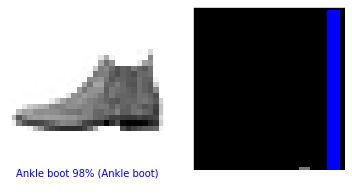

In [25]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

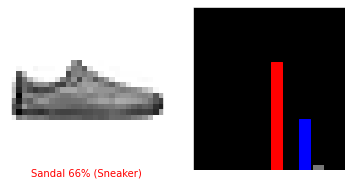

In [26]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

Nacrtajmo nekoliko slika na sličan način.

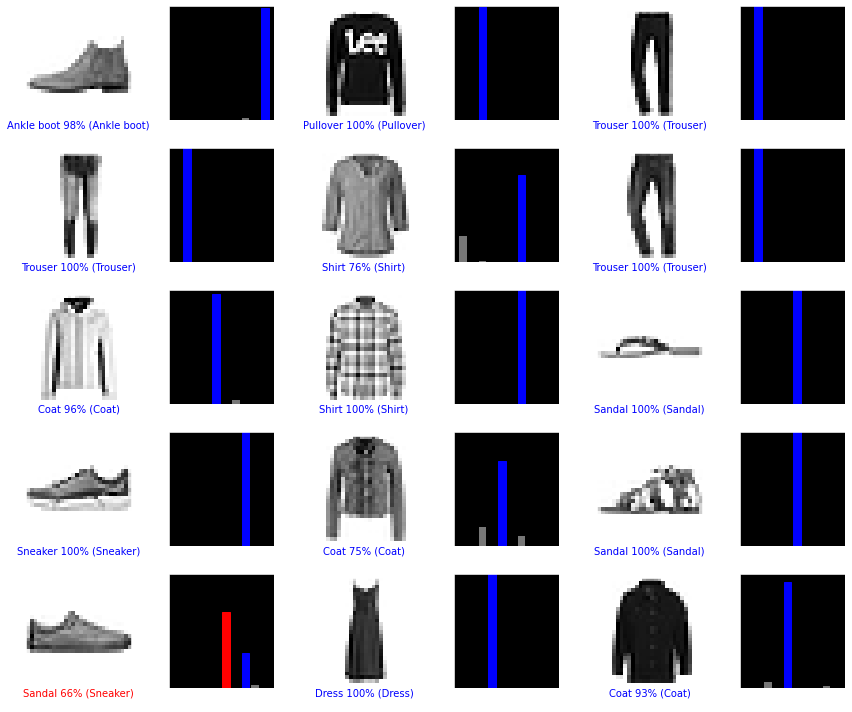

In [27]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

## Korišćenje modela

Šta ukoliko želimo da predvidimo klasu nad jednom slikom?

In [28]:
img = test_images[1]

print(img.shape)

(28, 28)


`tf.keras` modeli su optimizovani da radi predikcije na podskupu podataka
(eng. batch) u jednom prolazu (pogledajte prethodni primer gde smo dobili
predikcije nad **celim** skupom za testiranje). Usled toga neophodno je
(28, 28) prebaciti u oblik (1, 28, 28). Možete smatrati da je prva dimenzija
broj koji označava broj instanci koji se prosleđuje mreži.


In [29]:
img = (np.expand_dims(img, 0))

print(img.shape)

(1, 28, 28)


Vršimo predikciju nad slikom.

In [30]:
predictions_single = model.predict(img)

print(predictions_single)

[[2.9360969e-04 3.3696040e-10 9.9863380e-01 1.1161959e-08 6.1382650e-04
  2.3753037e-09 4.5878135e-04 1.7025253e-11 2.0106572e-08 4.9588053e-14]]


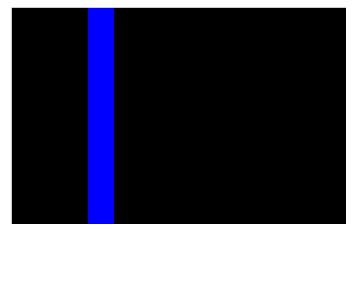

In [31]:
plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

`keras.Model.predict` nam vraća listu listi (usled rada na nivou podskupa)
pa ćemo uzeti prvi element te liste.


In [32]:
np.argmax(predictions_single[0])

2